In [ ]:
%tensorflow_version 2.x

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [ ]:
data = pd.read_csv('/content/sample_data/creditcard.csv')
print(data.shape)
data.head()

**EDA:**

In [ ]:
data.describe()

In [ ]:
data.isnull().sum()

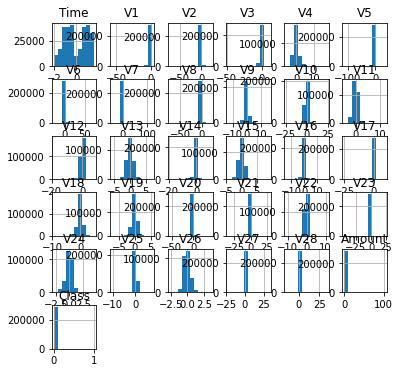

In [ ]:
data.hist(figsize=(6, 6))
plt.show()

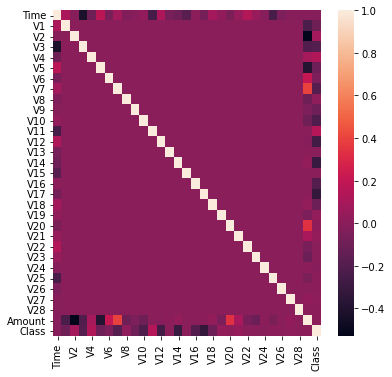

In [ ]:
corr_mat = data.corr()
fig = plt.figure(figsize = (6, 6))
sns.heatmap(corr_mat)
plt.show()

In [ ]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

**Feature Engineering**

In [ ]:
def impute_missing(df, feature):
  impute_value = df[feature].mean()
  df[feature + "_nan"] = np.where(df[feature].isna(), 1, 0)
  df[feature] = df[feature].fillna(impute_value)
  return df

def one_hot_encoding(df, feature):
  ohe = OneHotEncoder()
  transformed = ohe.fit_transform(df[[feature]])
  df[feature+'_'+ohe.categories_[0]] = transformed.toarray()
  df_transformed = X.drop([feature], axis=1)
  return df_transformed

def scaling(df, feature):
  scaler = StandardScaler()
  df[feature] = scaler.fit_transform(df[feature])
  return df

In [ ]:
scale_features = ["Time", "Amount"]

for feature in scale_features:
  data_scaled = scaling(data, [feature])
data_scaled.describe()

In [ ]:
X = data_scaled.drop("Class", axis=1)
y = data_scaled["Class"]

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(182276, 30)
(45569, 30)
(56962, 30)


In [ ]:
neg = y_train.value_counts()[0]
pos = y_train.value_counts()[1]
print(neg, pos)

181946 330


under_sampling, over_sampling or weight punishments

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

sampler = RandomUnderSampler()
X_train_undersampling, y_train_undersampling = sampler.fit_resample(X_train, y_train)
print(X_train_undersampling.shape, y_train_undersampling.shape)

(660, 30) (660,)


In [ ]:
weight_neg = 1 - (neg / (neg+pos))
weight_pos = 1 - (pos / (neg+pos))
weight_class = {0: weight_neg, 1: weight_pos}
print(weight_class)

{0: 0.001810441308784494, 1: 0.9981895586912155}


**Modeling**

**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

y_pred = rfc.predict(X_test)

precision = precision_score(y_test, y_pred)
print("Precision: {}".format(precision))

recall = recall_score(y_test, y_pred)
print("Recall: {}".format(recall))

f1 = f1_score(y_test, y_pred)
print("F1: {}".format(f1))

auc = roc_auc_score(y_test, y_pred)
print("AUC: {}".format(auc))

Precision: 0.9871794871794872
Recall: 0.7857142857142857
F1: 0.8750000000000001
AUC: 0.892848349947745


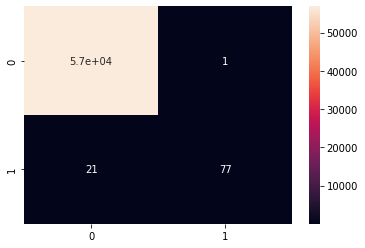

In [ ]:
con_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(con_mat, annot=True)

In [ ]:
fig = plt.figure(figsize = (12, 9))
plt.barh(X_train.columns, rfc.feature_importances_)

**DNN**

In [ ]:
input_dim = X_train.shape[-1]
dropout_rate = 0.3

model = keras.Sequential(
    [
     keras.layers.Dense(256, activation='relu', input_dim=input_dim, kernel_regularizer=keras.regularizers.l2(0.01)),
     keras.layers.Dropout(dropout_rate),
     keras.layers.BatchNormalization(),
     keras.layers.Dense(256, activation='relu'),
     keras.layers.Dropout(dropout_rate),
     keras.layers.BatchNormalization(), 
     keras.layers.Dense(256, activation='relu'),
     keras.layers.Dropout(dropout_rate),
     keras.layers.BatchNormalization(), 
     keras.layers.Dense(1, activation='sigmoid')
    ]
)
model.summary()

In [ ]:
learning_rate = 1e-4
metrics = [
           keras.metrics.TruePositives(name='TP'),
           keras.metrics.FalsePositives(name='FP'),
           keras.metrics.FalseNegatives(name='FN'),
           keras.metrics.TrueNegatives(name='TN'),
           keras.metrics.Precision(name="precision"),
           keras.metrics.Recall(name="recall"),
           keras.metrics.AUC(name="PRAUC", curve="PR")
]

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss="binary_crossentropy", metrics=metrics)

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(monitor="loss", patience=20)]
batch_size = 1024
epochs = 100

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs, callbacks=callbacks, class_weight=weight_class)

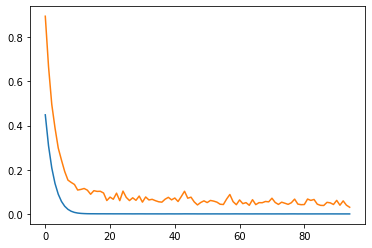

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [ ]:
test_scores = model.evaluate(X_test, y_test, batch_size=batch_size)

56/56 [==============================] - 1s 11ms/step - loss: 0.0313 - TP: 86.0000 - FP: 280.0000 - FN: 12.0000 - TN: 56584.0000 - precision: 0.2350 - recall: 0.8776 - PRAUC: 0.7005
